# Install Required Libraries

| Library        | Purpose                                                                   |
| -------------- | ------------------------------------------------------------------------- |
| `transformers` | From Hugging Face. Lets us load LLaMA-2 and other language models easily. |
| `accelerate`   | Helps load large models (like LLaMA-2 7B) on GPU/CPU seamlessly.          |
| `torch`        | PyTorch — the deep learning framework used by LLaMA-2.                    |




In [55]:
!pip install transformers accelerate torch --quiet

# Login to Hugging Face

LLaMA-2 is gated by Meta — you must accept the license and be approved.

Once approved, you can use your Hugging Face token to access the model

In [56]:
from huggingface_hub import notebook_login
notebook_login()

# Import the necessary libraries

In [57]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load LLaMA 2 - 7B model and tokenizer

tokenizer turns text into tokens (numbers).

model is the actual LLaMA-2 7B model. We're using:

*   torch_dtype=torch.float16: Uses half-precision to save memory.
*   device_map="auto": Puts model on GPU if available.



In [58]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Code for Visualization

In [59]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def visualize_embeddings(embeddings, title, labels=None):
    # embeddings shape: (1, sequence_length, hidden_dim)
    embeddings = embeddings.squeeze(0).cpu().numpy()

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], palette='viridis', s=100)

    # Annotate with tokens
    if labels:
        for i, label in enumerate(labels):
            plt.text(reduced[i, 0] + 0.02, reduced[i, 1], label, fontsize=12)

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

# Input Text From User

In [70]:
input_text = input("Enter your text here: ")

Enter your text here: Cricket is a


# Tokenize It

In [71]:
tokens = tokenizer(input_text, return_tensors="pt")
input_ids = tokens["input_ids"].to(model.device)
attention_mask = tokens["attention_mask"]

print("🔹 Tokens:", tokenizer.convert_ids_to_tokens(input_ids[0]))
print("🔹 Input IDs:", input_ids)
print("🔹 Attension Mask:", attention_mask)

🔹 Tokens: ['<s>', '▁Cr', 'icket', '▁is', '▁a']
🔹 Input IDs: tensor([[   1, 6781, 8522,  338,  263]])
🔹 Attension Mask: tensor([[1, 1, 1, 1, 1]])


# Get token embeddings

In [72]:
with torch.no_grad():
    token_embeddings = model.model.embed_tokens(input_ids)
print("🧠 Token Embeddings Shape:", token_embeddings.shape)

🧠 Token Embeddings Shape: torch.Size([1, 5, 4096])


# Visualize Token Embeddings

/tmp/ipython-input-59-2925602524.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], palette='viridis', s=100)


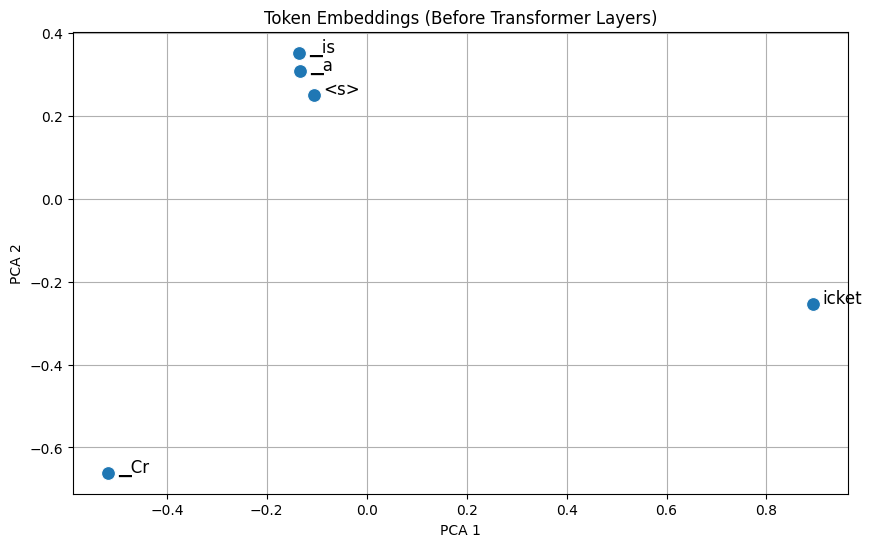

In [73]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
visualize_embeddings(token_embeddings, title="Token Embeddings (Before Transformer Layers)", labels=tokens)

# Get The Outputs & It's logits

In [74]:
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

# Get the output of the 1st transformer layer

In [75]:
first_layer_output = outputs.hidden_states[1]  # Index 1 = after first layer
print("✅ Output After 1st Transformer Layer:", first_layer_output.shape)

✅ Output After 1st Transformer Layer: torch.Size([1, 5, 4096])


# Visualize 1st Layer Output Embeddings

/tmp/ipython-input-59-2925602524.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], palette='viridis', s=100)


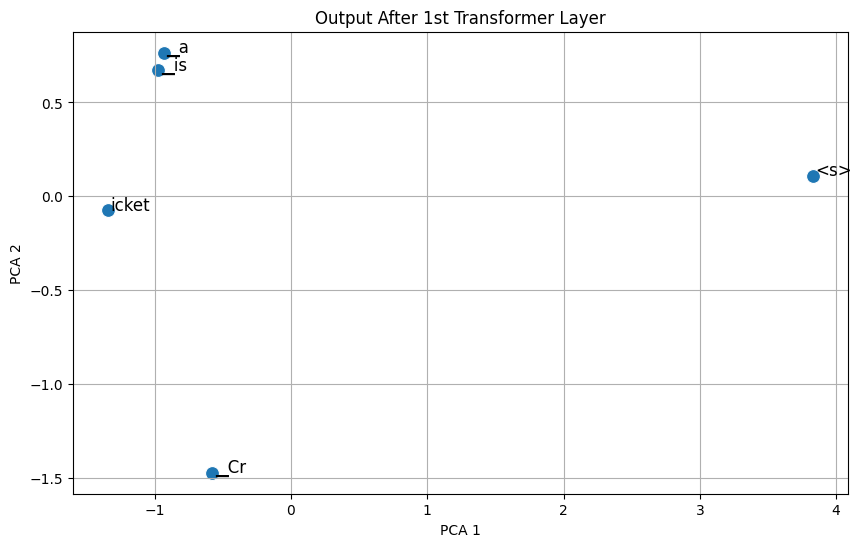

In [76]:
first_layer_output = outputs.hidden_states[1]  # After first transformer block
visualize_embeddings(first_layer_output, title="Output After 1st Transformer Layer", labels=tokens)

# Final Embedding (Last Layer Output)

In [77]:
final_output = outputs.hidden_states[-1]
print("✅ Final Embedding (Last Layer Output) Shape:", final_output.shape)

✅ Final Embedding (Last Layer Output) Shape: torch.Size([1, 5, 4096])


# Visualize Final Layer Output

/tmp/ipython-input-59-2925602524.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], palette='viridis', s=100)


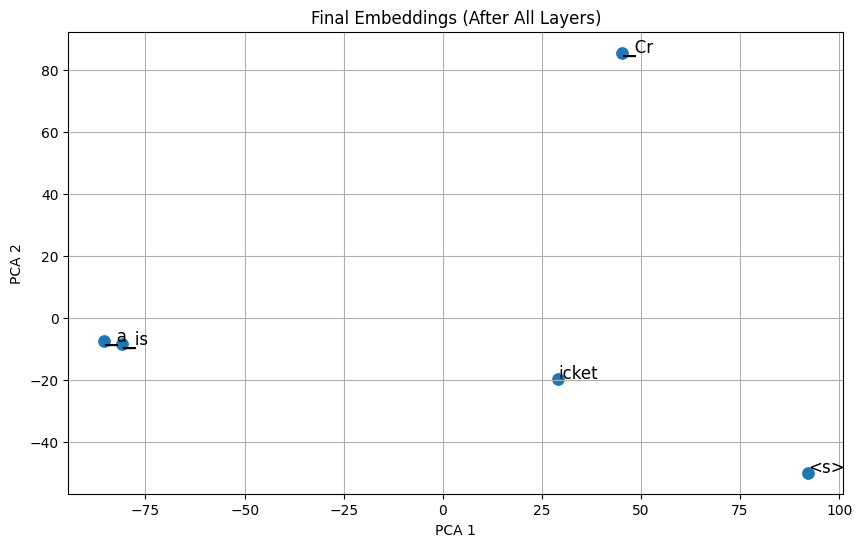

In [78]:
final_output = outputs.hidden_states[-1]
visualize_embeddings(final_output, title="Final Embeddings (After All Layers)", labels=tokens)

# Predicted Next Token: & Top 5 tokens with probability

In [79]:
import torch.nn.functional as F


# Step 2: Focus on the last token in the sequence
last_token_logits = logits[:, -1, :]  # (1, vocab_size)

# Step 3: Convert logits to probabilities
probs = F.softmax(last_token_logits, dim=-1)

# Step 4: Get the most probable next token
predicted_token_id = torch.argmax(probs, dim=-1).item()
predicted_token = tokenizer.decode(predicted_token_id)

print(f"\n🔮 Predicted Next Token: '{predicted_token}'")

top_k = 5
top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)

for i in range(top_k):
    token = tokenizer.decode(top_indices[0, i])
    prob = top_probs[0, i].item()
    print(f"🔝 {i+1}: {token!r} (prob: {prob:.4f})")


🔮 Predicted Next Token: 'game'
🔝 1: 'game' (prob: 0.1456)
🔝 2: 'bat' (prob: 0.1400)
🔝 3: 'sport' (prob: 0.1207)
🔝 4: 'team' (prob: 0.0682)
🔝 5: 'popular' (prob: 0.0511)
